<a href="https://colab.research.google.com/github/linainsaf/ML-M1/blob/main/Performance_d'un_classifieur_(_ROC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

On travaille sur des images de la base Pratheepan Dataset
(http://cs-chan.com/
downloads_skin_ dataset.html) dont on souhaite détecter les pixels de teinte chaire afin
d’accélérer un algorithme de détection de visages. Pour cela, la vérité de terrain a été déterminée
pour chaque image. On a récupéré dans X_train, y_train, les pixels des 26 premières images et
dans X_test, y_test, ceux des 4 dernières images. Seul un pixel sur 2000 a été conservé pour
avoir des temps de calcul raisonnables. X_ est composé des composantes chromatiques Cb, Cr
de chaque pixel et y_ est composé de la classe du pixel, 1 si couleur peau, 0 sinon.

I. Chargement et visualisation des données

(1, 639, 2)


<function matplotlib.pyplot.show>

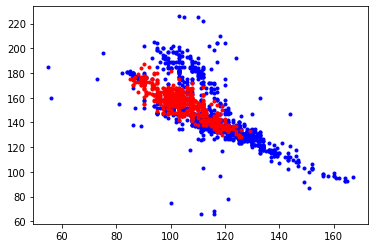

In [ ]:
[X_train, y_train, X_test, y_test] = np.load("TP3.npy",allow_pickle=True)
#Pixel peau
T_train = X_train[np.where(y_train==1),:]
T_train = np.reshape(T_train,(T_train.shape[1],T_train.shape[2] ))
#Pixel non peau
F_train = X_train[np.where(y_train==0),:]
F_train = np.reshape(F_train,(F_train.shape[1],F_train.shape[2] ))
plt.plot(F_train[:,0], F_train[:,1], '.b')
plt.show
plt.plot(T_train[:,0], T_train[:,1], '.r')
plt.show

In [ ]:
print("il y a ",F_train[:,0].shape," pixels de teinte non chair en bleu")
print("il y a ",T_train[:,0].shape," pixels de teinte chair en rouge")

il y a  (1731,)  pixels de teinte non chair en bleu
il y a  (639,)  pixels de teinte chair en rouge


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((2370, 2), (2370,), (284, 2), (284,))

II. Modélisation de la densité de probabilité a priori de la teinte chaire par une loi
normale 2D avec des dimensions décorrélées

Comme il est difficile de modéliser tout ce qui n’est pas teinte chaire, on décide de travailler avec une seule classe, la teinte chaire, dont on estime la densité de probabilité a priori. 𝑝(𝒙/𝑐ℎ𝑎𝑖𝑟).

a. Estimation de la densité de probabilité a priori des pixels de teinte chaire

On modélise la densité de probabilité a priori des pixels de teinte chaire 𝑝(𝒙/𝑐ℎ𝑎𝑖𝑟), 𝒙 = [𝐶𝑏, 𝐶𝑟] sur la base d’apprentissage par une loi normale 2D avec des dimensions décorrélées.
𝑚Cb, 𝑚Cr, 𝜎Cb, 𝜎Cr représentent les moyennes et écarts-type de chacune des composantes.

Déterminer 𝑚Cb, 𝑚Cr, 𝜎Cb, 𝜎Cr.

In [ ]:
m_cb=np.mean(T_train[:,0])
m_cr=np.mean(T_train[:,1])
s_cb=np.std(T_train[:,0])
s_cr=np.std(T_train[:,1])
m_cb

104.29577464788733

In [ ]:
def norm1(x, m, s):
  p =1/(math.sqrt(2*math.pi)*s)*math.exp(-(x-m)*(x-m)/(2*s*s))
  return p

In [ ]:
p1_train=np.zeros(len(y_train))
for i in range(len(y_train)):  
  p1_train[i]=norm1(X_train[i,0],m_cb,s_cb)*norm1(X_train[i,1],m_cr,s_cr)

In [ ]:
p1_train.shape

(2370,)

In [ ]:
p1_test=np.zeros(len(y_test))
for i in range(len(y_test)):  
  p1_test[i]=norm1(X_test[i,0],m_cb,s_cb)*norm1(X_test[i,1],m_cr,s_cr)
p1_test.shape

(284,)

In [ ]:
seuil= np.mean(p1_train)
def calcule(X_test,y_test,p1_test,seuil):
  TP=0 
  TN=0
  FP=0
  FN=0
  for i in range(len(X_test)): 
    if (p1_test[i]>seuil): 
      if y_test[i]==1: 
        TP=TP+1 
      else : 
        FP=FP+1 
    else : 
      if y_test[i]==0: 
        TN=TN+1 
      else:
        FN=FN+1 
  return TP,TN,FP,FN


In [ ]:
calcule(X_test=X_test,y_test=y_test,p1_test=p1_test,seuil=seuil)

(102, 120, 60, 2)

Courbe ROC:

Plutôt que de choisir un seuil arbitraire, on choisit 20 valeurs de seuils régulièrement réparties entre min(P1_train) et max(P1_

1.4102993270174741e-19


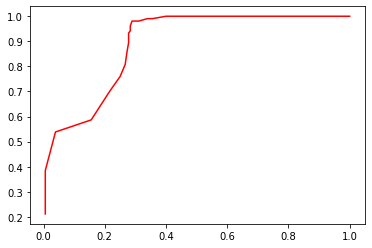

In [ ]:
NB = 20
step = (np.max(p1_train) - np.min(p1_train) ) / NB
SEUILS = np.arange (np.min(p1_train), np.max(p1_train), step)
print(SEUILS[0])
cov = np.cov(np.transpose(T_train)) 
sensibilite = np.zeros(NB)
specificite=np.zeros(NB)
TP,TN,FP,FN=np.zeros(NB),np.zeros(NB),np.zeros(NB),np.zeros(NB)
for i in range(NB):
  TP[i],TN[i],FP[i],FN[i]=calcule(X_test,y_test,p1_test,seuil=SEUILS[i])
  sensibilite[i]=TP[i]/(TP[i]+FN[i])
  specificite[i]=TN[i]/(TN[i]+FP[i])
plt.plot(1-specificite,sensibilite,'r')

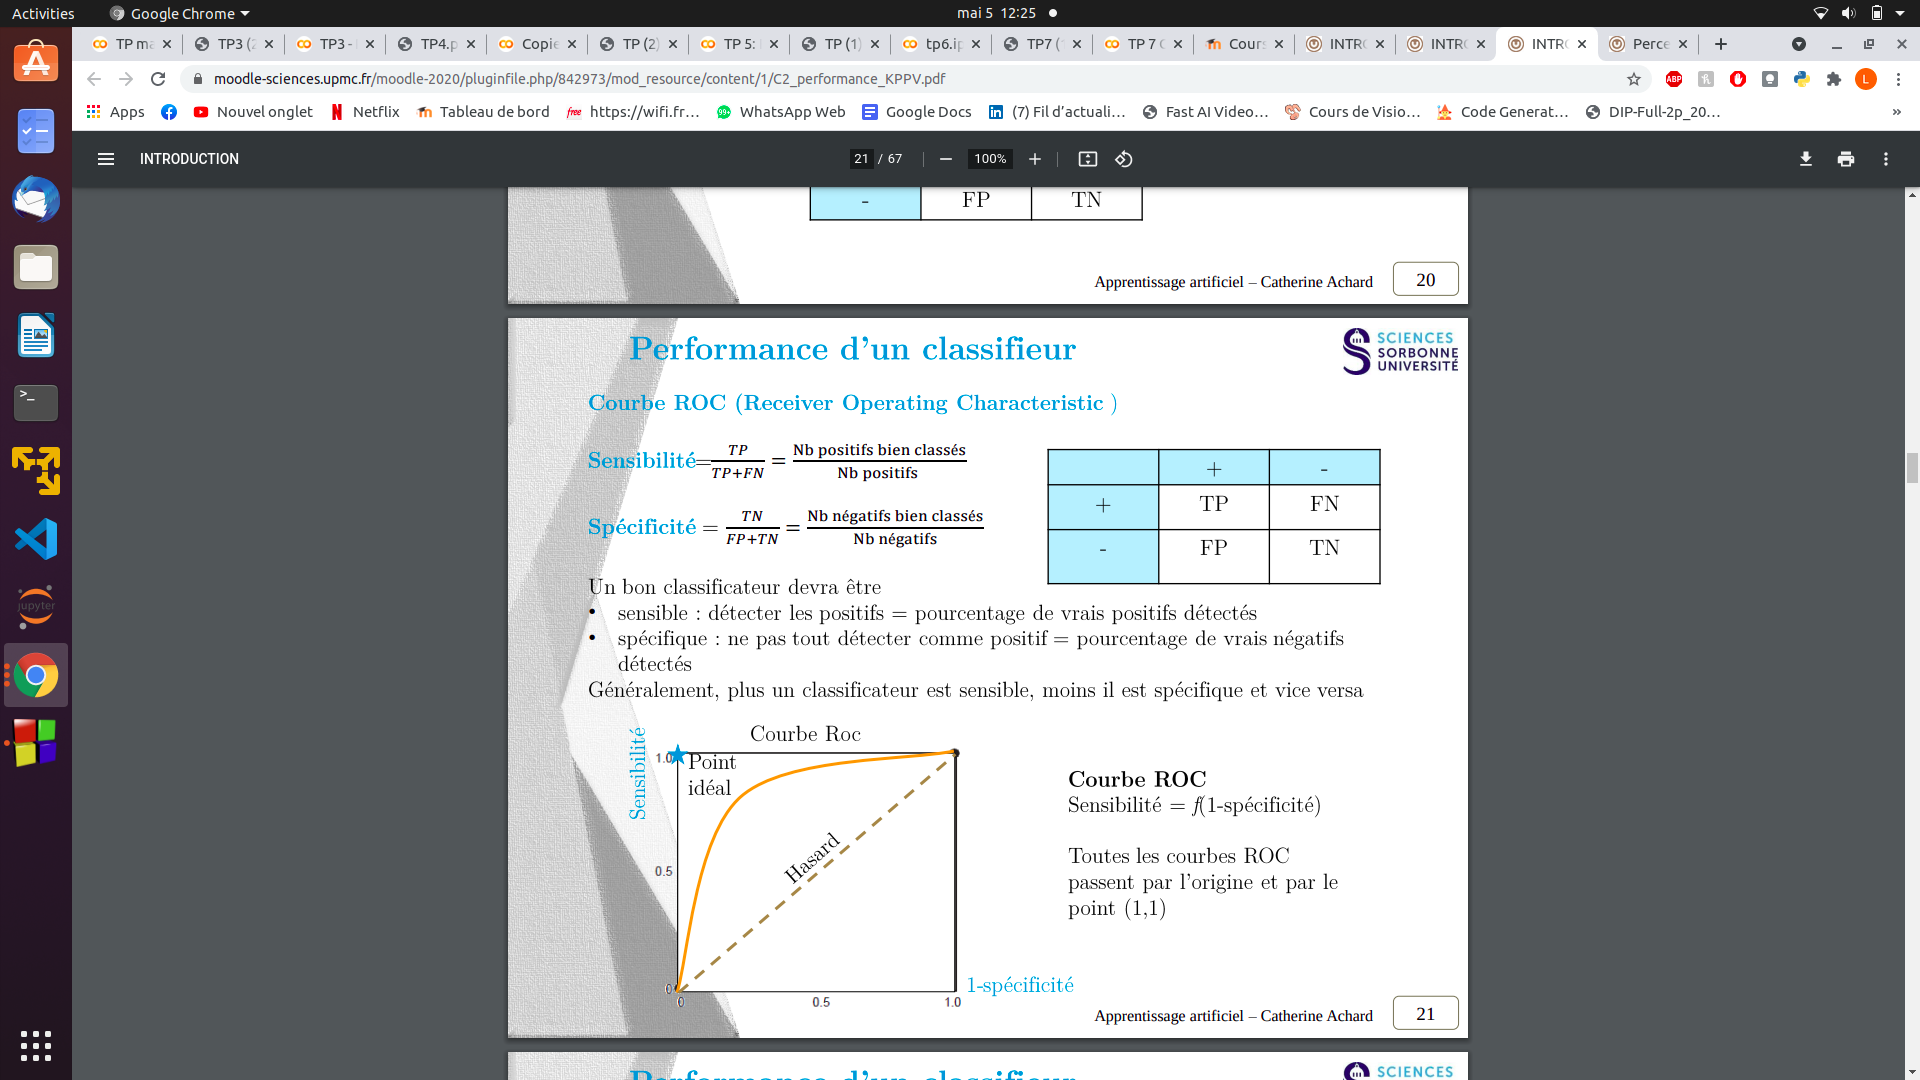

Modélisation de la densité de probabilité a priori de la teinte chaire par une loi normale 2D

In [ ]:
def norm2(x, m, cov):
  a = np.dot(np.transpose((x-m)), np.linalg.inv(cov))
  a = np.dot(a, (x-m)) 
  p =1/(math.sqrt(2*math.pi*np.linalg.det(cov)))*math.exp(-0.5*a) 
  return p 

In [ ]:
seuil= np.mean(p1_train)
def calcule1(X_test,y_test,p2_test,seuil):
  TP=0 
  TN=0
  FP=0
  FN=0
  for i in range(len(X_test)): 
    if (p2_test[i]>seuil): 
      if y_test[i]==1: 
        TP=TP+1 
      else : 
        FP=FP+1 
    else : 
      if y_test[i]==0: 
        TN=TN+1 
      else:
        FN=FN+1 
  return TP,TN,FP,FN

In [ ]:
cov=np.cov(T_train.T)
m=np.mean(T_train.T)
m


129.74491392801252

In [ ]:
p2_train=np.zeros(len(y_train))
for i in range(len(y_train)):  
  p2_train[i]=norm2(X_train[i],m,cov)
p2_train.shape

(2370,)

In [ ]:
p2_test=np.zeros(len(y_test))
for i in range(len(y_test)):  
  p2_test[i]=norm2(X_test[i],m,cov)
p2_test.shape

(284,)

2.1595125267783573e-48


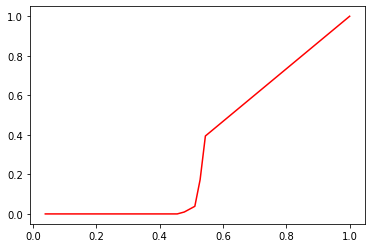

In [ ]:
NB = 20
step = (np.max(p2_train) - np.min(p2_train) ) / NB
SEUILS = np.arange (np.min(p2_train), np.max(p2_train), step)
print(SEUILS[0])
sensibilite = np.zeros(NB)
specificite=np.zeros(NB)
TP,TN,FP,FN=np.zeros(NB),np.zeros(NB),np.zeros(NB),np.zeros(NB)
for i in range(NB):
  TP[i],TN[i],FP[i],FN[i]=calcule(X_test,y_test,p2_test,seuil=SEUILS[i])
  sensibilite[i]=TP[i]/(TP[i]+FN[i])
  specificite[i]=TN[i]/(TN[i]+FP[i])
plt.plot(1-specificite,sensibilite,'r')